In [1]:
from sdm.utils import set_project_wd
set_project_wd()

Current Working Directory: /Users/work/Data Science/sheffield-bats


In [2]:
import pandas as pd
from pathlib import Path
import rioxarray as rxr
import xarray as xr


In [3]:

ev_folder = Path("data/evs/")
# list the tifs
ev_tifs = list(ev_folder.glob("*.tif"))
ev_tifs

[PosixPath('data/evs/climate_stats.tif'),
 PosixPath('data/evs/wind.tif'),
 PosixPath('data/evs/os-feature-cover-100m.tif'),
 PosixPath('data/evs/os-distance-to-feature.tif'),
 PosixPath('data/evs/terrain-stats.tif'),
 PosixPath('data/evs/bioclim.tif'),
 PosixPath('data/evs/temp_average.tif'),
 PosixPath('data/evs/precipitation.tif'),
 PosixPath('data/evs/ceh-land-cover-100m.tif'),
 PosixPath('data/evs/dtm-100m.tif'),
 PosixPath('data/evs/veg-height-100m.tif')]

In [4]:

# read the tifs into a list of xarray objects
evs = [rxr.open_rasterio(ev_tif, band_as_variable=True) for ev_tif in ev_tifs]
# Name each EV using the filename
for ev, ev_tif in zip(evs, ev_tifs):
    ev.attrs["file_name"] = ev_tif.stem

In [5]:
def assign_band_names(ds):
    if "long_name" not in ds["band_1"].attrs:
        return ds
    band_names = {var: ds[var].attrs["long_name"] for var in ds.data_vars}
    renamed_ds = ds.rename(band_names)
    return renamed_ds

evs = [assign_band_names(ev) for ev in evs]

In [6]:
# Prefix band names with the file_name for each dataset
evs = [ev.rename({var: f"{ev.attrs['file_name']}_{var}" for var in ev.data_vars}) for ev in evs]

In [7]:
ev_stack = xr.merge(evs)
ev_stack

<xarray.Dataset> Size: 262MB
Dimensions:                                         (x: 792, y: 563)
Coordinates:
  * x                                               (x) float64 6kB 4.039e+05...
  * y                                               (y) float64 5kB 4.268e+05...
    spatial_ref                                     int64 8B 0
Data variables: (12/97)
    climate_stats_temp_ann_var                      (y, x) float64 4MB ...
    climate_stats_temp_ann_avg                      (y, x) float64 4MB ...
    climate_stats_temp_mat_avg                      (y, x) float64 4MB ...
    climate_stats_prec_ann_var                      (y, x) float64 4MB ...
    climate_stats_prec_ann_avg                      (y, x) float64 4MB ...
    climate_stats_wind_ann_var                      (y, x) float64 4MB ...
    ...                                              ...
    ceh-land-cover-100m_Upland Heathland            (y, x) float64 4MB ...
    ceh-land-cover-100m_Wetland                     (y, x) float64 4MB ...
    dtm-100m_LIDAR_Composite_2m_DTM_2022_Elevation  (y, x) float32 2MB ...
    veg-height-100m_veg_height_mean                 (y, x) float32 2MB ...
    veg-height-100m_veg_height_std                  (y, x) float32 2MB ...
    veg-height-100m_veg_height_max                  (y, x) float32 2MB ...
Attributes:
    AREA_OR_POINT:  Area
    file_name:      climate_stats

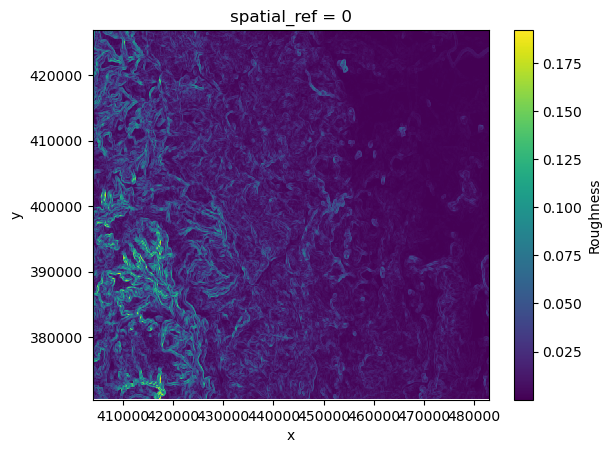

In [8]:
ev_stack["terrain-stats_Roughness"].plot()

# Run some Checks

In [9]:
ev_df = ev_stack.to_dataframe()
ev_df.head()

spatial_ref  climate_stats_temp_ann_var  \
x             y                                                        
403914.879459 426796.145539            0                         NaN   
              426696.051974            0                         NaN   
              426595.958408            0                         NaN   
              426495.864843            0                         NaN   
              426395.771277            0                         NaN   

                             climate_stats_temp_ann_avg  \
x             y                                           
403914.879459 426796.145539                         NaN   
              426696.051974                         NaN   
              426595.958408                         NaN   
              426495.864843                         NaN   
              426395.771277                         NaN   

                             climate_stats_temp_mat_avg  \
x             y                                           
403914.879459 426796.145539                         NaN   
              426696.051974                         NaN   
              426595.958408                         NaN   
              426495.864843                         NaN   
              426395.771277                         NaN   

                             climate_stats_prec_ann_var  \
x             y                                           
403914.879459 426796.145539                         NaN   
              426696.051974                         NaN   
              426595.958408                         NaN   
              426495.864843                         NaN   
              426395.771277                         NaN   

                             climate_stats_prec_ann_avg  \
x             y                                           
403914.879459 426796.145539                         NaN   
              426696.051974                         NaN   
              426595.958408                         NaN   
              426495.864843                         NaN   
              426395.771277                         NaN   

                             climate_stats_wind_ann_var  \
x             y                                           
403914.879459 426796.145539                         NaN   
              426696.051974                         NaN   
              426595.958408                         NaN   
              426495.864843                         NaN   
              426395.771277                         NaN   

                             climate_stats_wind_ann_avg  wind_wind_1  \
x             y                                                        
403914.879459 426796.145539                         NaN          NaN   
              426696.051974                         NaN          NaN   
              426595.958408                         NaN          NaN   
              426495.864843                         NaN          NaN   
              426395.771277                         NaN          NaN   

                             wind_wind_2  ...  ceh-land-cover-100m_Urban  \
x             y                           ...                              
403914.879459 426796.145539          NaN  ...                        0.0   
              426696.051974          NaN  ...                     1200.0   
              426595.958408          NaN  ...                     6200.0   
              426495.864843          NaN  ...                      900.0   
              426395.771277          NaN  ...                        0.0   

                             ceh-land-cover-100m_Suburban  \
x             y                                             
403914.879459 426796.145539                           0.0   
              426696.051974                        4000.0   
              426595.958408                        3600.0   
              426495.864843                        2900.0   
              426395.771277                       

In [10]:
ev_df.drop(columns=["spatial_ref"], inplace=True)

## Missing Values

There should be some missing values where I've clipped the data using a buffer but it should be less than 30%.

In [11]:
# Count the missing values per variable and sor tin descending order
ev_df.isna().mean().sort_values(ascending=False)

terrain-stats_tpi                       0.006069
terrain-stats_Roughness                 0.006069
os-feature-cover-100m_water             0.005609
os-feature-cover-100m_minor_roads       0.005472
os-feature-cover-100m_woodland          0.005416
                                          ...   
terrain-stats_slope                     0.000000
terrain-stats_aspect_eastness_slope     0.000000
terrain-stats_aspect_northness_slope    0.000000
terrain-stats_curvature                 0.000000
veg-height-100m_veg_height_max          0.000000
Length: 97, dtype: float64

Where are the missing values in the dataset?

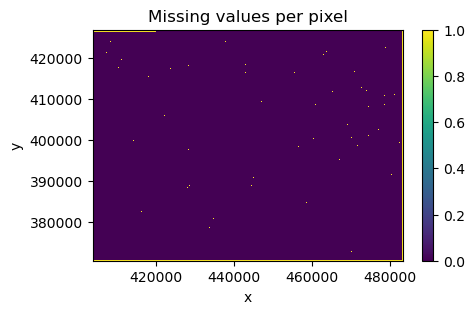

In [12]:
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 3))
np.isnan(ev_stack.to_array()).any(axis=0).plot(ax = ax)
# add title
ax.set_title("Missing values per pixel")

plt.show()


In [13]:
ev_df.dropna(inplace=True)

ev_correlations = ev_df.corr()
ev_correlations.head()

,climate_stats_temp_ann_var,climate_stats_temp_ann_avg,climate_stats_temp_mat_avg,climate_stats_prec_ann_var,climate_stats_prec_ann_avg,climate_stats_wind_ann_var,climate_stats_wind_ann_avg,wind_wind_1,wind_wind_2,wind_wind_3,...,ceh-land-cover-100m_Urban,ceh-land-cover-100m_Suburban,ceh-land-cover-100m_Grassland,"ceh-land-cover-100m_Marine, Littoral",ceh-land-cover-100m_Upland Heathland,ceh-land-cover-100m_Wetland,dtm-100m_LIDAR_Composite_2m_DTM_2022_Elevation,veg-height-100m_veg_height_mean,veg-height-100m_veg_height_std,veg-height-100m_veg_height_max
climate_stats_temp_ann_var,1.000000,0.835245,0.863569,-0.873919,-0.867827,-0.831071,-0.705102,-0.757363,-0.751403,-0.716525,...,0.135420,0.093598,-0.339713,0.003712,-0.281747,-0.260257,-0.840390,-0.043054,-0.016523,0.015616
climate_stats_temp_ann_avg,0.835245,1.000000,0.996155,-0.914492,-0.949483,-0.942222,-0.848749,-0.885837,-0.892617,-0.873137,...,0.162875,0.174726,-0.429740,0.022920,-0.325442,-0.499521,-0.974273,0.003262,0.068901,0.136002
climate_stats_temp_mat_avg,0.863569,0.996155,1.000000,-0.912733,-0.945034,-0.941522,-0.851380,-0.888032,-0.893750,-0.874213,...,0.174660,0.181933,-0.422000,0.018646,-0.322647,-0.485162,-0.969380,0.003724,0.069936,0.136763
climate_stats_prec_ann_var,-0.873919,-0.914492,-0.912733,1.000000,0.991523,0.937832,0.784290,0.843032,0.840282,0.805867,...,-0.073723,-0.041868,0.317797,-0.029709,0.308212,0.468048,0.958065,0.000710,-0.031216,-0.066291
climate_stats_prec_ann_avg,-0.867827,-0.949483,-0.945034,0.991523,1.000000,0.944079,0.792404,0.849268,0.849946,0.817116,...,-0.083303,-0.063458,0.350099,-0.031819,0.314379,0.475268,0.979171,0.002083,-0.036012,-0.077437


Some of the correlations ar NA because the values are all 0 in the dataset. This is where that land cover feature doesn't exist inland and should just be converted to NA.

In [14]:
ev_correlations.fillna(0, inplace=True)

/var/folders/w6/z6wv9w5s4r77c8m0lp63lm1w0000gp/T/ipykernel_87756/1657080385.py:7: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(distance, method='ward')


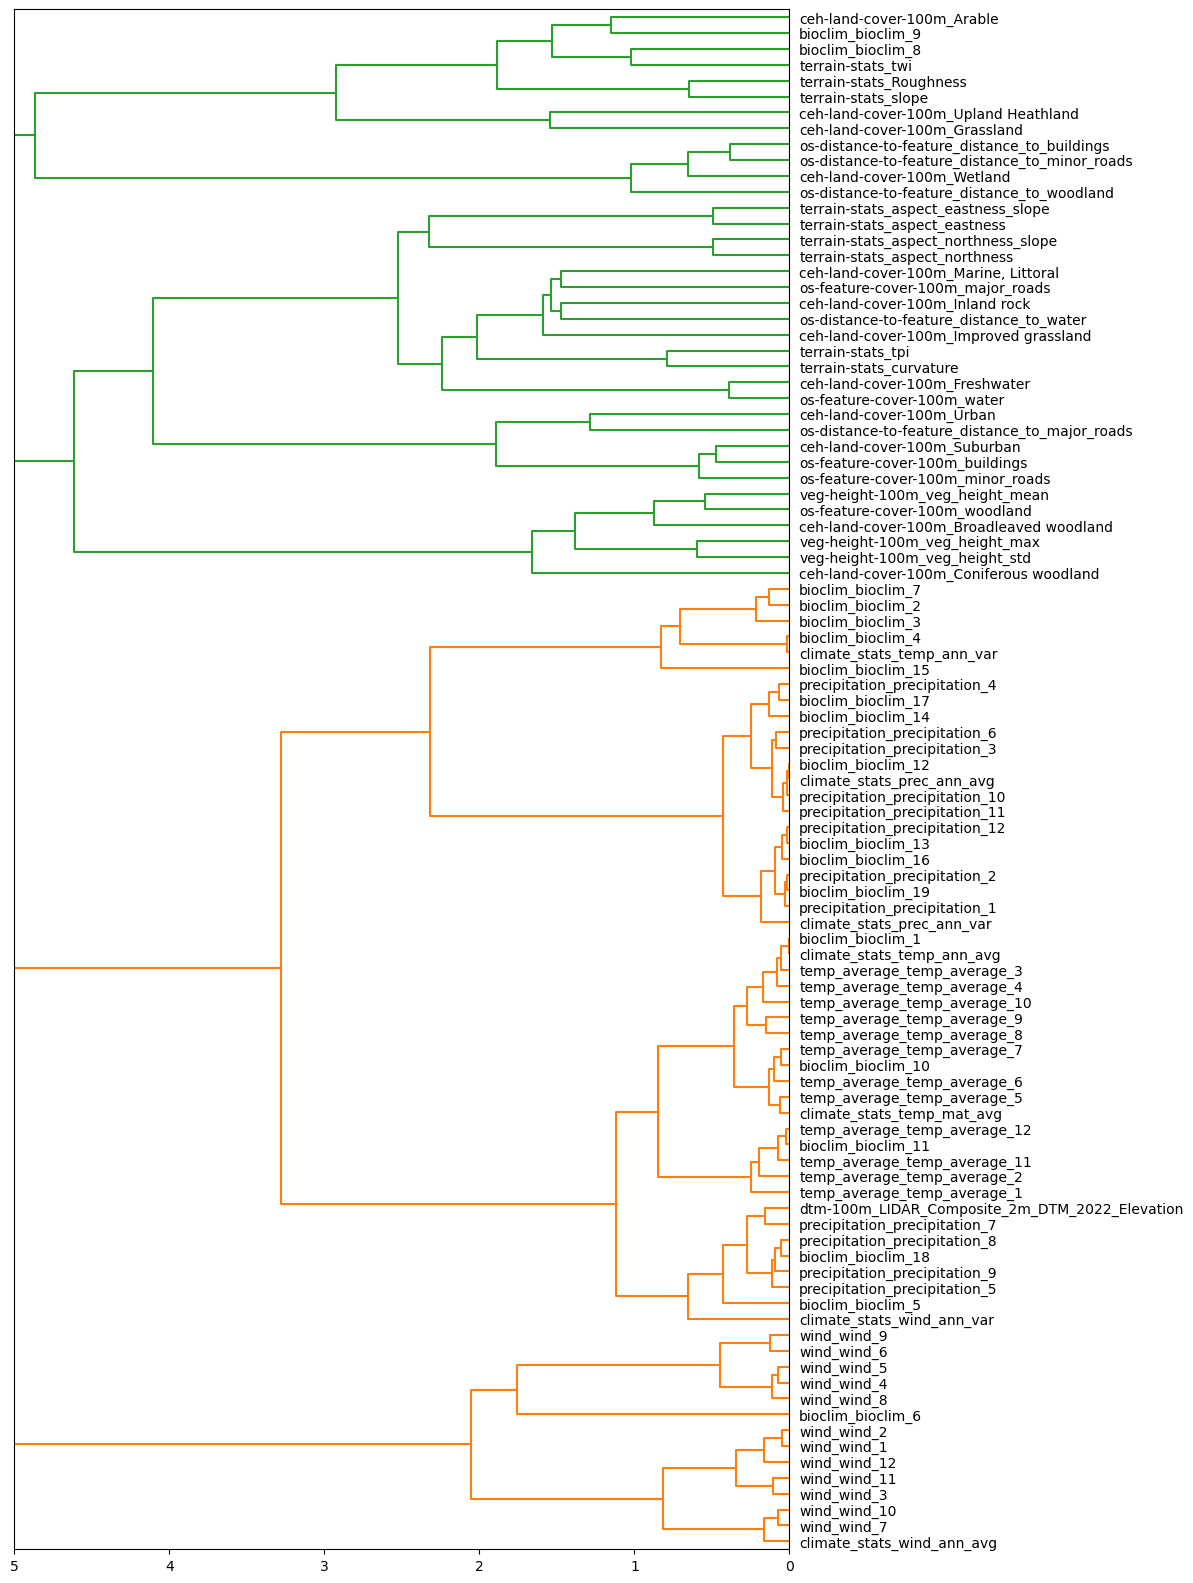

In [15]:
from scipy.cluster import hierarchy

# Calculate distance between each variable (1 - correlation to have a sense of distance)
distance = 1 - ev_correlations.abs()

# Perform hierarchical clustering
linkage_matrix = hierarchy.linkage(distance, method='ward')

plt.figure(figsize=(10,20))
hierarchy.dendrogram(linkage_matrix, labels=ev_correlations.columns.tolist(), orientation="left", leaf_font_size=10)
plt.xlim(5, 0)
plt.show()

In [18]:

plt.figure(figsize=(8,6))

cut_height = 1.2
hierarchy.dendrogram(
    linkage_matrix,
    no_labels=True, 
    orientation="left",
    color_threshold=cut_height,
    )
# add a vertical line to mark the threshold
plt.axvline(x=cut_height, color='orange', linestyle='--')
plt.xlim(5, 0)
# drop the panel
plt.gca().set_axis_off()
background_color = "#eeeeee"
# set panel background color
plt.gca().patch.set_facecolor(background_color)
plt.show()

SyntaxError: unmatched ')' (1383925992.py, line 2)

In [16]:
# Cluster the samples
cluster_ids = hierarchy.fcluster(linkage_matrix, t=1.2, criterion='distance')

# Create a DataFrame to see clusters
column_clusters = pd.DataFrame({'cluster_id': cluster_ids, 'column_name': ev_df.columns})
print(column_clusters.cluster_id.value_counts().sort_index())

1      8
2      5
3      1
4     25
5     16
6      6
7      2
8      3
9      1
10     3
11     1
12     1
13     2
14     2
15     1
16     1
17     1
18     1
19     1
20     2
21     2
22     4
23     1
24     1
25     2
26     2
27     2
Name: cluster_id, dtype: int64


In [17]:
column_clusters = column_clusters.sort_values("cluster_id")
column_clusters.to_csv("data/evs/ev_clusters.csv", index=False)